<a href="https://colab.research.google.com/github/Ayush-Raj-Chourasia/Crackathon_RDD/blob/main/Crackathon_RDD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
anulayakhare_crackathon_data_path = kagglehub.dataset_download('anulayakhare/crackathon-data')

print('Data source import complete.')

Using Colab cache for faster access to the 'crackathon-data' dataset.
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful pack9ages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Streaming output truncated to the last 5000 lines.
/kaggle/input/crackathon-data/randomized_dataset/train/images/002022.jpg
/kaggle/input/crackathon-data/randomized_dataset/train/images/000384.jpg
/kaggle/input/crackathon-data/randomized_dataset/train/images/016333.jpg
/kaggle/input/crackathon-data/randomized_dataset/train/images/007900.jpg
/kaggle/input/crackathon-data/randomized_dataset/train/images/020701.jpg
/kaggle/input/crackathon-data/randomized_dataset/train/images/025700.jpg
/kaggle/input/crackathon-data/randomized_dataset/train/images/006217.jpg
/kaggle/input/crackathon-data/randomized_dataset/train/images/033053.jpg
/kaggle/input/crackathon-data/randomized_dataset/train/images/030142.jpg
/kaggle/input/crackathon-data/randomized_dataset/train/images/026433.jpg
/kaggle/input/crackathon-data/randomized_dataset/train/images/000370.jpg
/kaggle/input/crackathon-data/randomized_dataset/train/images/009530.jpg
/kaggle/input/crackathon-data/randomized_dataset/train/images/018604.jpg


In [ ]:
# Install Ultralytics (if not already installed). On Kaggle this is allowed.
# If this cell shows messages about restarting kernel, run it and then re-run from the top.
!pip install -q ultralytics==8.3.246 ultralytics-thop

# Print versions
import importlib, sys
import ultralytics
print("Ultralytics version:", ultralytics.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.6 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics version: 8.3.246


In [ ]:
# Standard imports
import os, sys, glob, shutil, zipfile, json, time
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import random
import cv2

# Auto-detect dataset root in /kaggle/input
BASE = "/kaggle/input"
assert os.path.exists(BASE), "/kaggle/input does not exist — are you running on Kaggle?"

def find_dataset_root():
    # Look for a directory that contains train/val/test or randomized_dataset subfolder
    for d in os.listdir(BASE):
        root = os.path.join(BASE, d)
        if not os.path.isdir(root):
            continue
        # direct structure check
        if all(os.path.exists(os.path.join(root, s)) for s in ["train","val"]):
            return root
        # sometimes the dataset contains randomized_dataset folder
        candidate = os.path.join(root, "randomized_dataset")
        if os.path.isdir(candidate) and all(os.path.exists(os.path.join(candidate, s)) for s in ["train","val"]):
            return candidate
    raise FileNotFoundError("Couldn't find dataset root in /kaggle/input. Please check dataset is added to notebook.")

DATASET_ROOT = find_dataset_root()
print("Detected DATASET_ROOT =", DATASET_ROOT)

# Define expected subfolders
TRAIN_IMG_DIR = os.path.join(DATASET_ROOT, "train", "images")
TRAIN_LBL_DIR = os.path.join(DATASET_ROOT, "train", "labels")
VAL_IMG_DIR   = os.path.join(DATASET_ROOT, "val", "images")
VAL_LBL_DIR   = os.path.join(DATASET_ROOT, "val", "labels")
TEST_IMG_DIR  = os.path.join(DATASET_ROOT, "test", "images")

# Quick sanity print
for p in [TRAIN_IMG_DIR, TRAIN_LBL_DIR, VAL_IMG_DIR, VAL_LBL_DIR, TEST_IMG_DIR]:
    print(p, "->", "Exists" if os.path.exists(p) else "MISSING")


Detected DATASET_ROOT = /kaggle/input/crackathon-data/randomized_dataset
/kaggle/input/crackathon-data/randomized_dataset/train/images -> Exists
/kaggle/input/crackathon-data/randomized_dataset/train/labels -> Exists
/kaggle/input/crackathon-data/randomized_dataset/val/images -> Exists
/kaggle/input/crackathon-data/randomized_dataset/val/labels -> Exists
/kaggle/input/crackathon-data/randomized_dataset/test/images -> Exists


In [ ]:
# Helper to list files with certain extensions
def list_files(path, exts=('jpg','jpeg','png','bmp','tif','tiff')):
    if not os.path.exists(path):
        return []
    files = []
    for ext in exts:
        files.extend(sorted(glob.glob(os.path.join(path, f'*.{ext}'))))
    return files


In [ ]:
# Count images & labels
train_imgs = list_files(TRAIN_IMG_DIR)
val_imgs = list_files(VAL_IMG_DIR)
train_lbls = sorted(glob.glob(os.path.join(TRAIN_LBL_DIR, '*.txt'))) if os.path.exists(TRAIN_LBL_DIR) else []
val_lbls = sorted(glob.glob(os.path.join(VAL_LBL_DIR, '*.txt'))) if os.path.exists(VAL_LBL_DIR) else []

print(f"Train images: {len(train_imgs)}, Train labels: {len(train_lbls)}")
print(f"Val   images: {len(val_imgs)}, Val   labels: {len(val_lbls)}")

# Missing labels
def missing_labels(img_list, lbl_dir):
    missing = []
    for img in img_list:
        stem = Path(img).stem
        if not os.path.exists(os.path.join(lbl_dir, stem + ".txt")):
            missing.append(img)
    return missing

train_missing = missing_labels(train_imgs, TRAIN_LBL_DIR)
val_missing = missing_labels(val_imgs, VAL_LBL_DIR)
print("Train images with missing label files:", len(train_missing))
print("Val images with missing label files:", len(val_missing))

# Duplicate label detection (same line duplicated)
def duplicate_label_files(lbl_list):
    dup = []
    for f in lbl_list:
        with open(f,'r') as fh:
            lines = [l.strip() for l in fh if l.strip()]
        if len(lines) != len(set(lines)):
            dup.append(f)
    return dup

print("Train dup label files:", len(duplicate_label_files(train_lbls)))
print("Val dup label files:", len(duplicate_label_files(val_lbls)))

# Class frequency
def class_counts(lbl_dir):
    cnt = Counter()
    if not os.path.exists(lbl_dir):
        return cnt
    for txt in glob.glob(os.path.join(lbl_dir, '*.txt')):
        with open(txt,'r') as fh:
            for ln in fh:
                parts = ln.strip().split()
                if len(parts) >= 1:
                    try:
                        cls = int(float(parts[0]))
                        cnt[cls] += 1
                    except:
                        pass
    return cnt

train_counts = class_counts(TRAIN_LBL_DIR)
val_counts = class_counts(VAL_LBL_DIR)
print("Train class counts:", train_counts)
print("Val class counts:", val_counts)


Train images: 26385, Train labels: 26385
Val   images: 6000, Val   labels: 6000
Train images with missing label files: 0
Val images with missing label files: 0
Train dup label files: 3
Val dup label files: 0
Train class counts: Counter({0: 17807, 1: 8133, 3: 7281, 2: 7224, 4: 4450})
Val class counts: Counter({0: 4093, 1: 1830, 3: 1737, 2: 1698, 4: 1085})


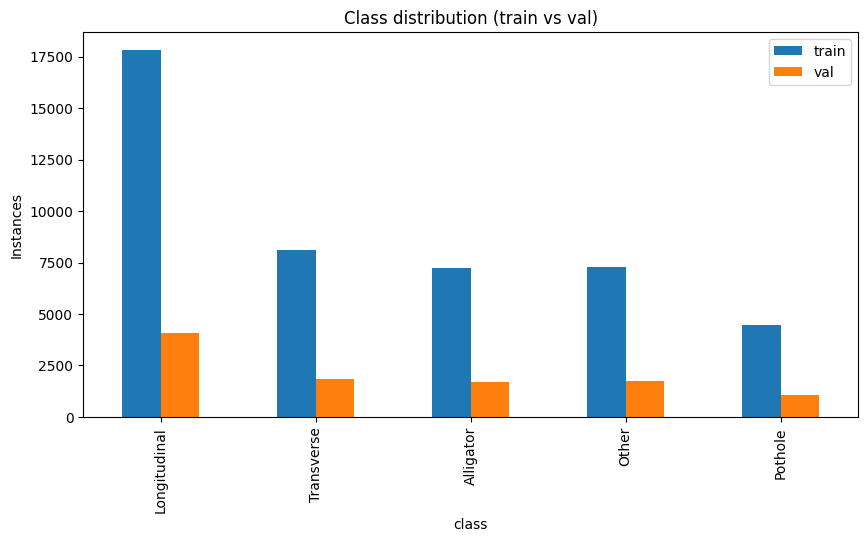

In [ ]:
# Plot train class counts
classes = {0: 'Longitudinal', 1: 'Transverse', 2: 'Alligator', 3: 'Other', 4: 'Pothole'}
train_counts_list = [train_counts.get(i,0) for i in range(len(classes))]
val_counts_list = [val_counts.get(i,0) for i in range(len(classes))]

df = pd.DataFrame({
    "class": [classes[i] for i in classes],
    "train": train_counts_list,
    "val": val_counts_list
})
df.set_index('class', inplace=True)
df.plot(kind='bar', figsize=(10,5), title='Class distribution (train vs val)')
plt.ylabel("Instances")
plt.show()


Image: /kaggle/input/crackathon-data/randomized_dataset/train/images/033238.jpg
Image: /kaggle/input/crackathon-data/randomized_dataset/train/images/000890.jpg
Image: /kaggle/input/crackathon-data/randomized_dataset/train/images/026015.jpg


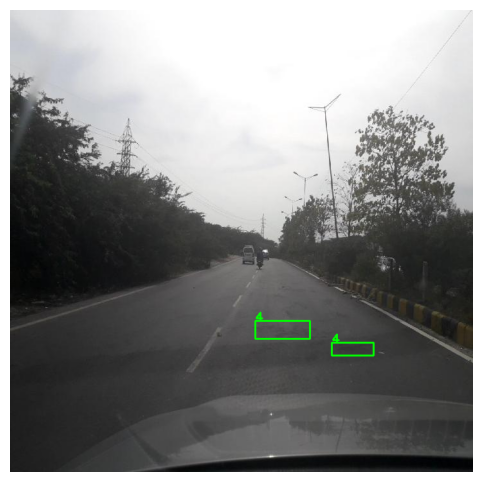

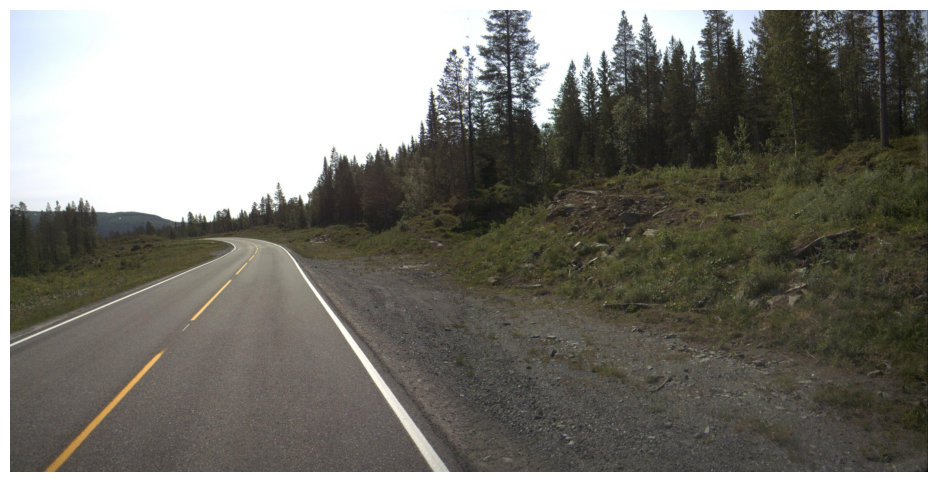

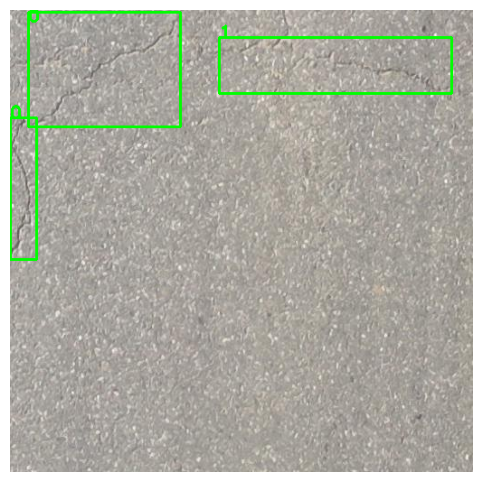

In [ ]:
# Visualize a few random labeled images
def show_image_with_boxes(img_path, lbl_path, max_boxes=100):
    img = cv2.imread(img_path)
    if img is None:
        print("Failed to read", img_path); return
    h, w = img.shape[:2]
    with open(lbl_path,'r') as fh:
        lines = [l.strip() for l in fh if l.strip()]
    for line in lines[:max_boxes]:
        parts = line.split()
        cls = int(float(parts[0]))
        xc, yc, bw, bh = list(map(float, parts[1:5]))
        x1 = int((xc - bw/2) * w)
        y1 = int((yc - bh/2) * h)
        x2 = int((xc + bw/2) * w)
        y2 = int((yc + bh/2) * h)
        cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
        cv2.putText(img, str(cls), (max(0,x1), max(12,y1)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
    # Convert BGR to RGB for matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12,6)); plt.imshow(img_rgb); plt.axis('off')

# Show 3 random examples from train (if labeled)
examples = [p for p in train_imgs if os.path.exists(os.path.join(TRAIN_LBL_DIR, Path(p).stem + '.txt'))]
random.shuffle(examples)
for img in examples[:3]:
    lbl = os.path.join(TRAIN_LBL_DIR, Path(img).stem + '.txt')
    print("Image:", img)
    show_image_with_boxes(img, lbl)


In [ ]:
import yaml
data_yaml = {
    "path": DATASET_ROOT,
    "train": "train/images",
    "val": "val/images",
    "names": {
        0: "Longitudinal crack",
        1: "Transverse crack",
        2: "Alligator crack",
        3: "Other corruption",
        4: "Pothole"
    }
}
with open("data.yaml","w") as f:
    yaml.dump(data_yaml, f, sort_keys=False)
print("Wrote data.yaml with path:", DATASET_ROOT)


Wrote data.yaml with path: /kaggle/input/crackathon-data/randomized_dataset


In [ ]:
from ultralytics import YOLO
import pandas as pd

PROJECT_DIR = "/kaggle/working/road_damage"
RUN_NAME = "yolo11m_final"
os.makedirs(PROJECT_DIR, exist_ok=True)

CSV_LOG = "training_metrics_yolo11m.csv"

def get_resume_weights(project_dir=PROJECT_DIR, run_name=RUN_NAME):
    last_ckpt = Path(project_dir)/run_name/'weights'/'last.pt'
    best_ckpt = Path(project_dir)/run_name/'weights'/'best.pt'
    if last_ckpt.exists():
        return str(last_ckpt), True
    if best_ckpt.exists():
        return str(best_ckpt), False
    return "yolo11m.pt", False

def log_metrics(results):
    # results from ultralytics model.train may be a list or object; handle safely
    try:
        metrics = {
            "epoch": getattr(results, "epoch", None),
            "map50": results.metrics.box.map50 if hasattr(results, "metrics") else None,
            "map50_95": results.metrics.box.map if hasattr(results, "metrics") else None,
            "precision": results.metrics.box.mp if hasattr(results, "metrics") else None,
            "recall": results.metrics.box.mr if hasattr(results, "metrics") else None
        }
    except Exception as e:
        metrics = {"info": str(e)}
    pd.DataFrame([metrics]).to_csv(CSV_LOG, mode="a", header=not os.path.exists(CSV_LOG), index=False)
    print("Logged metrics to", CSV_LOG)


In [ ]:
# # Get resume checkpoint if available
# model_path, resume_flag = get_resume_weights()
# print("Model path:", model_path, " Resume:", resume_flag)

# # Instantiate model
# model = YOLO(model_path)

# # Training hyperparameters (as required)
# EPOCHS=120
# IMGSZ=768
# BATCH=12
# DEVICE=0  # Kaggle GPU device index

# # Safety: if small GPU memory, reduce batch or imgsz gracefully
# # You can change these if you run out of memory.
# try:
#     results = model.train(
#         data="data.yaml",
#         epochs=EPOCHS,
#         imgsz=IMGSZ,
#         batch=BATCH,
#         device=DEVICE,
#         project=PROJECT_DIR,
#         name=RUN_NAME,
#         resume=resume_flag,
#         save=True,
#         save_period=5,
#         # optimization & augmentation
#         optimizer='SGD',
#         lr0=0.008,
#         lrf=0.01,
#         weight_decay=0.0007,
#         box=8.0,
#         cls=1.2,
#         dfl=1.5,
#         mosaic=1.0,
#         mixup=0.1,
#         close_mosaic=15,
#         patience=30,
#         amp=True,
#         val=True
#     )
#     log_metrics(results)
#     print("Training completed.")
# except Exception as e:
#     print("Training failed:", e)
#     print("Try reducing BATCH or IMGSZ and re-run the cell. Example: BATCH=8 or IMGSZ=640")


In [ ]:
# ---------------------------
# CELL 10 replacement: Robust YOLO11m training starter
# ---------------------------
import torch
from ultralytics import YOLO
from pathlib import Path

# Use existing helper to find resume weights (defined earlier)
model_path, resume_flag = get_resume_weights()
print("Resume weights:", model_path, " resume_flag:", resume_flag)

# instantiate model (this only loads weights/meta, not heavy GPU ops)
model = YOLO(model_path)

# Detect CUDA availability and set training hyperparams accordingly
cuda_available = torch.cuda.is_available()
print("torch.cuda.is_available():", cuda_available)
print("torch.cuda.device_count():", torch.cuda.device_count())

if cuda_available:
    device = 0               # use GPU 0 (Ultralytics accepts int or '0')
    amp_flag = True
    EPOCHS = 120
    IMGSZ = 768
    BATCH = 12               # adjust downward if OOM
    print("GPU detected — using full training config (IMGSZ=768, BATCH=12, AMP=True).")
else:
    device = "cpu"           # must be string 'cpu' when no GPU
    amp_flag = False
    # CPU fallback: keep a short debug run to verify pipeline; NOT full training
    EPOCHS = 5               # short run on CPU — increase only if you understand the runtime cost
    IMGSZ = 640              # smaller for CPU
    BATCH = 4                # small batch for CPU
    print("WARNING: No GPU detected. Training YOLO11m on CPU is VERY SLOW.")
    print("If you want full training, enable a GPU in Notebook Settings (Kaggle: Notebook -> Settings -> Accelerator -> GPU), restart kernel, and re-run.")
    print("Current fallback: EPOCHS=5, IMGSZ=640, BATCH=4, AMP disabled.")

# Safety caps
MIN_BATCH = 1
MIN_IMGSZ = 384

# Training loop with simple OOM/exception handling and backoff
max_attempts = 3
attempt = 0
trained = False
last_exception = None

while attempt < max_attempts and not trained:
    attempt += 1
    try:
        print(f"\n=== Training attempt {attempt}/{max_attempts} ===")
        print(f"device={device}, amp={amp_flag}, epochs={EPOCHS}, imgsz={IMGSZ}, batch={BATCH}")

        results = model.train(
            data="data.yaml",
            epochs=EPOCHS,
            imgsz=IMGSZ,
            batch=BATCH,
            device=device,
            project=PROJECT_DIR,
            name=RUN_NAME,
            resume=resume_flag,
            save=True,
            save_period=5,
            optimizer='SGD',
            lr0=0.008,
            lrf=0.01,
            weight_decay=0.0007,
            box=8.0,
            cls=1.2,
            dfl=1.5,
            mosaic=1.0,
            mixup=0.1,
            close_mosaic=15,
            patience=30,
            amp=amp_flag,
            val=True
        )
        # If training returns without exception, mark success and log metrics
        log_metrics(results)
        print("Training completed successfully.")
        trained = True

    except Exception as e:
        last_exception = e
        err_str = str(e).lower()
        print(f"Training attempt {attempt} failed with exception:\n{e}")

        # If it's a CUDA/Device error and we expected GPU, switch to CPU fallback
        if "invalid cuda" in err_str or "no cuda" in err_str or "cuda" in err_str and not cuda_available:
            print("Detected CUDA/device related error. Switching to CPU fallback.")
            device = "cpu"
            amp_flag = False
            EPOCHS = 5
            IMGSZ = max(MIN_IMGSZ, IMGSZ - 128)
            BATCH = max(MIN_BATCH, BATCH // 2)
            print(f"New fallback settings: device={device}, imgsz={IMGSZ}, batch={BATCH}, epochs={EPOCHS}")
            continue

        # For OOM / out of memory errors, reduce batch / imgsz and retry
        if "out of memory" in err_str or "oom" in err_str or "cuda out of memory" in err_str:
            old_batch, old_imgsz = BATCH, IMGSZ
            BATCH = max(MIN_BATCH, BATCH // 2)
            IMGSZ = max(MIN_IMGSZ, IMGSZ - 128)
            print(f"OOM detected — reducing resources and retrying: BATCH {old_batch} -> {BATCH}, IMGSZ {old_imgsz} -> {IMGSZ}")
            continue

        # For any other exception, print it and break (don't infinite loop)
        print("Non-recoverable exception. See traceback above. Aborting training attempts.")
        break

if not trained:
    print("\n=== Training did not complete successfully ===")
    if last_exception is not None:
        print("Last exception:", last_exception)
    print("Recommendations:")
    print("- If you are on Kaggle, enable GPU in Notebook Settings (Accelerator -> GPU), restart kernel, re-run the notebook.")
    print("- If you must run on CPU, expect VERY long training times. Consider using a smaller model (e.g., yolo11s) or reduced epochs.")
else:
    print("\nYou can find checkpoints at:", os.path.join(PROJECT_DIR, RUN_NAME, "weights"))


Resume weights: yolo11m.pt  resume_flag: False
torch.cuda.is_available(): True
torch.cuda.device_count(): 1
GPU detected — using full training config (IMGSZ=768, BATCH=12, AMP=True).

=== Training attempt 1/3 ===
device=0, amp=True, epochs=120, imgsz=768, batch=12
Ultralytics 8.3.246 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=8.0, cache=False, cfg=None, classes=None, close_mosaic=15, cls=1.2, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=120, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=768, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.008, lrf=0.01, mask_ratio=4,

In [ ]:
import os

project_weights_dir = os.path.join("/kaggle/working/road_damage", "yolo11m_final", "weights")

print(f"Listing contents of: {project_weights_dir}")
if os.path.exists(project_weights_dir):
    for item in os.listdir(project_weights_dir):
        print(item)
else:
    print(f"Directory not found: {project_weights_dir}")

Listing contents of: /kaggle/working/road_damage/yolo11m_final/weights
Directory not found: /kaggle/working/road_damage/yolo11m_final/weights
